# Dataset Making

In [1]:
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
from nltk import RegexpTokenizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

C:\Users\chris\Anaconda3\envs\fastai\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
toker = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')

In [3]:
csv = pd.read_csv("temp.csv")
urls = csv['Image Link'].values

In [4]:
img = io.imread(urls[0], as_gray=True)

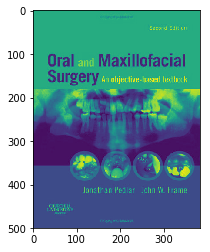

In [5]:
plt.imshow(img)

In [98]:
os.getcwd()

'C:\\Users\\chris\\Documents\\other_projects\\UQCS\\CoverThis\\hacky_ai'

In [95]:
d2v.save('./title.doc2vec')

In [6]:
d2v = Doc2Vec(vector_size=64)
docs = csv['Title'].values
d2v.build_vocab([TaggedDocument(toker.tokenize(doc), [i]) for i, doc in enumerate(docs)])

In [7]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import matplotlib.pyplot as plt
import math

In [89]:
ds[0]

(
 1.00000e-03 *
  -4.8499
  -7.4893
   7.0218
   2.3852
   5.5278
   4.6834
  -4.6412
   7.2146
  -7.5420
   0.0837
   7.0384
   5.0761
  -7.7824
   5.2021
  -4.4834
  -5.7063
  -6.4697
  -4.7963
   0.5935
  -1.4634
   1.4174
  -7.2042
  -7.3946
   1.5675
   7.5606
   5.0878
   2.0353
  -4.7912
  -4.4209
  -4.7801
   3.1879
  -1.0935
   6.6011
   1.7885
   4.3706
  -7.6497
  -2.2290
  -2.2065
   4.5395
  -4.7280
  -5.5018
   4.8719
  -6.4438
  -4.3617
  -3.0103
  -7.7817
  -6.1155
   2.6811
  -1.0711
  -0.8778
   7.4432
   1.4987
   7.1322
  -1.3382
   0.3223
   5.6659
  -6.8806
   3.7442
   2.8944
   3.0963
  -2.1104
  -0.2821
   3.8198
  -3.8488
 [torch.FloatTensor of size 64], 
 (0 ,.,.) = 
   0.4902  0.4902  0.4902  0.4902  0.4902  0.4980  0.5020  0.4980
   0.4706  0.4549  0.4902  0.4549  0.4510  0.4510  0.4588  0.4745
   0.4706  0.4157  0.4471  0.4706  0.4863  0.4980  0.5255  0.5137
   0.4235  0.4353  0.4314  0.3765  0.3765  0.4706  0.5216  0.4510
   0.2353  0.2824  0.2863  0.333

In [8]:
class DS(Dataset):
    def __init__(self, csv_path, d2v, transform=None):
        self.csv = pd.read_csv(csv_path)
        self.titles = csv['Title']
        self.vecs = [d2v.infer_vector(doc) for doc in self.titles]
        self.urls = csv['Image Link']
        self.transform = transform
    
    def __getitem__(self, idx):
        img = io.imread(self.urls[idx], as_gray=False)
        if self.transform is not None:
            img = self.transform(img)
        
        vec = self.vecs[idx]
        return torch.Tensor(vec), img
    
    def __len__(self):
        return 10

In [94]:
torch.__version__

'0.3.1.post2'

In [10]:
class Model(nn.Module):
    def __init__(self, ins, outs):
        super(Model, self).__init__()
        self.lin1 = nn.Linear(ins, 100)
        self.lin2 = nn.Linear(100, 100)
        self.lin3 = nn.Linear(100, outs)
        self.img_dims = (int(math.sqrt(outs)), int(math.sqrt(outs)))
    
    def forward(self, x):
        x = self.lin1(x)
        x = F.sigmoid(x)
        x = self.lin2(x)
        x = F.sigmoid(x)
        x = self.lin3(x)
        x = F.sigmoid(x)
        return x.view(self.img_dims)

# Training

In [81]:
num_epochs = 10
batch_size = 1
learning_rate = 1e-2
img_size = 8

In [82]:
tfms = transforms.Compose([transforms.ToPILImage(), transforms.Resize((img_size, img_size)), transforms.ToTensor()])

In [83]:
ds = DS("./temp.csv", d2v, transform=tfms)
dl = DataLoader(ds, shuffle=True)

In [84]:
model = Model(d2v.vector_size, img_size**2)

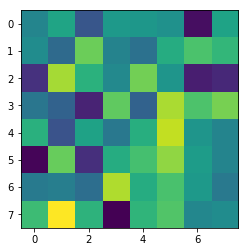

In [85]:
plt.imshow(model(Variable(ds[0][0])).data.numpy())

In [86]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [87]:
for epoch in range(num_epochs):
    for data in dl:
        img, _ = data
        img = Variable(img)

        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data[0]))
#     if epoch % 10 == 0:
#         pic = to_img(output.cpu().data)
#         save_image(pic, './dc_img/image_{}.png'.format(epoch))

epoch [1/10], loss:0.0001
epoch [2/10], loss:0.0000
epoch [3/10], loss:0.0000
epoch [4/10], loss:0.0000
epoch [5/10], loss:0.0000
epoch [6/10], loss:0.0000
epoch [7/10], loss:0.0000
epoch [8/10], loss:0.0000
epoch [9/10], loss:0.0000
epoch [10/10], loss:0.0000


In [72]:
ds.titles[0]

'Oral and Maxillofacial Surgery: An Objective-Based Textbook, 2e'

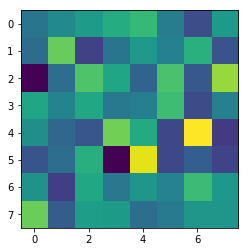

In [71]:
plt.imshow(model(Variable(ds[0][0])).data.numpy())